C:\Users\Cristiano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


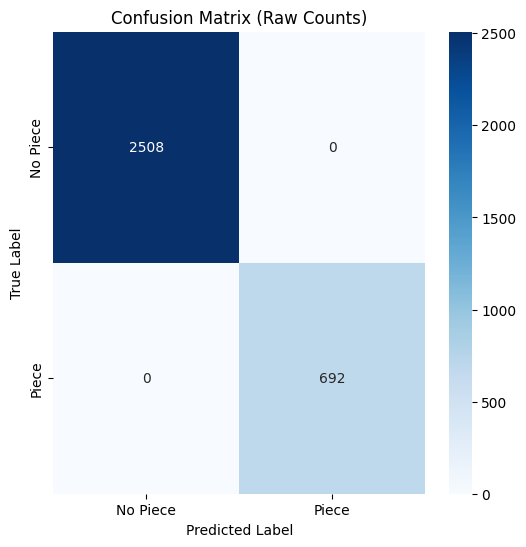


Examples of correct predictions:


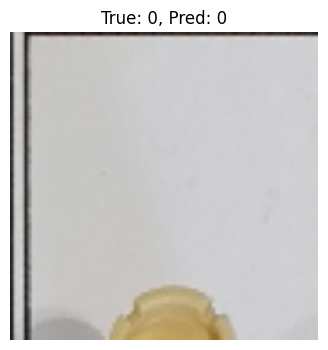

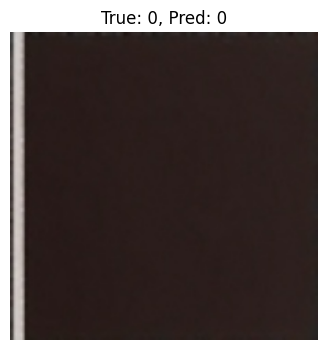

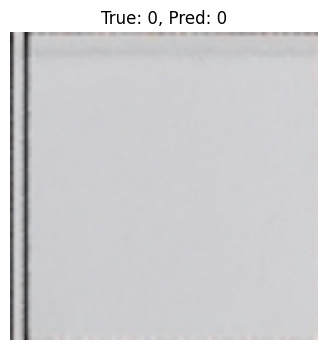

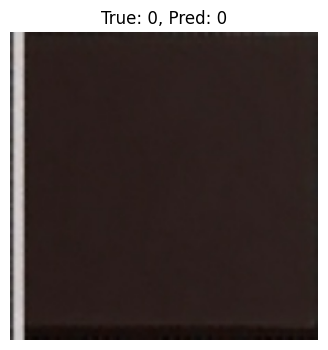

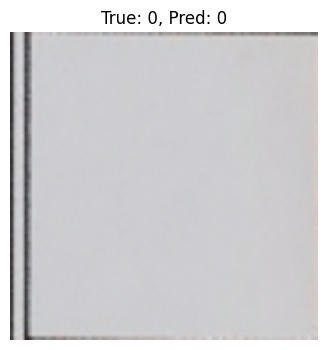


Examples of incorrect predictions:


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch import nn
from PIL import Image
import os

# Load the model from the saved state dict
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Function to evaluate the model and plot the confusion matrix
def evaluate_and_plot(model, val_loader, device, save_incorrect_dir='misclassified_images'):
    all_labels = []
    all_preds = []
    correct = []
    incorrect = []

    # Create the directory to save misclassified images
    if not os.path.exists(save_incorrect_dir):
        os.makedirs(save_incorrect_dir)

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            predictions = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int)
            labels_cpu = labels.cpu().numpy().astype(int)

            all_labels.extend(labels_cpu)
            all_preds.extend(predictions)

            for i in range(len(labels)):
                # Get the corresponding image path and prediction details
                image_path = val_loader.dataset.imgs[batch_idx * val_loader.batch_size + i][0]  # Get the correct image path
                label_cpu = labels_cpu[i][0]  # Extract the scalar value
                pred_cpu = predictions[i][0]  # Extract the scalar value
                if pred_cpu == label_cpu:
                    correct.append((image_path, label_cpu, pred_cpu))
                else:
                    incorrect.append((image_path, label_cpu, pred_cpu))
                    
                    # Save the misclassified image
                    save_misclassified_image(image_path, labels[i], predictions[i], save_incorrect_dir)

    # Compute confusion matrix with raw counts
    cm = confusion_matrix(np.array(all_labels), np.array(all_preds))

    # Plot the confusion matrix with raw counts
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Piece', 'Piece'], yticklabels=['No Piece', 'Piece'])
    plt.title('Confusion Matrix (Raw Counts)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Display some correct and incorrect examples
    show_examples(correct, incorrect)



# Function to save misclassified images
def save_misclassified_image(image_path, true_label, predicted_label, save_dir):
    # Get the image name from the path and create a new file name based on the labels
    image_name = os.path.basename(image_path)
    true_label = int(true_label)
    predicted_label = int(predicted_label)
    
    # Create a folder for each label if it doesn't exist
    label_dir = os.path.join(save_dir, f"True_{true_label}_Pred_{predicted_label}")
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
    
# Function to show correct and incorrect examples
def show_examples(correct, incorrect, num_examples=5, image_folder='labeled_squares'):
    print("\nExamples of correct predictions:")
    for i in range(min(num_examples, len(correct))):
        image_path, true_label, predicted_label = correct[i]
        
        # Open the image from the path
        img = Image.open(image_path)

        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"True: {true_label}, Pred: {predicted_label}")
        plt.axis('off')
        plt.show()

    print("\nExamples of incorrect predictions:")
    for i in range(min(num_examples, len(incorrect))):
        image_path, true_label, predicted_label = incorrect[i]
        
        # Open the image from the path
        img = Image.open(image_path)

        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"True: {true_label}, Pred: {predicted_label}")
        plt.axis('off')
        plt.show()
        plt.title(f"True: {int(true_label)}, Pred: {int(predicted_label)}")
        plt.axis('off')
        plt.show()



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model (you have already saved it)
model = models.resnet18(weights=False)
model.fc = nn.Linear(model.fc.in_features, 1)  # Adjust for your binary classification task
model = load_model(model, 'best_piece_classifier.pt')  # Load your saved model
model = model.to(device)  # Move the model to the same device as input tensors

# Prepare your validation dataset and dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset = datasets.ImageFolder('labeled_squares', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Now call the function to evaluate and plot the confusion matrix
evaluate_and_plot(model, val_loader, device)